In [1]:
import torch
import torch.nn as nn
import numpy as np
from ilb.env import MultiValleyMountainCarEnv

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = MultiValleyMountainCarEnv()

In [3]:
N = 256
gamma = 0.99
num_features = 32

In [4]:
from collections import OrderedDict
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self._fc_policy = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self._fc_policy(x)

# Load the trained policy
policy_net = PolicyNetwork().to(device)
state_dict = torch.load(r"D:\python_projects\pythonProject\state_distribution\models\net.pth", map_location=device)
policy_state = OrderedDict({k.replace('_fc_policy.', ''): v for k, v in state_dict.items() if k.startswith('_fc_policy')})
policy_net._fc_policy.load_state_dict(policy_state)
policy_net.eval()
print("Policy network loaded successfully!")

Policy network loaded successfully!


In [5]:
def sample_policy_action(policy_net, states):
    with torch.no_grad():
        logits = policy_net(states)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        actions = dist.sample()
    return actions

In [6]:
def sample_batch(policy_net, N, env, device):
    low = torch.tensor(env.low, dtype=torch.float32, device=device)
    high = torch.tensor(env.high, dtype=torch.float32, device=device)
    states = low + (high - low) * torch.rand(N, 2, device=device)

    actions = sample_policy_action(policy_net, states)
    next_states_list = []
    for s, a in zip(states.cpu().numpy(), actions.cpu().numpy()):
        env.state = s.copy()
        ns, _, _, _ = env.step(a)
        next_states_list.append(ns)
    next_states_np = np.array(next_states_list)
    next_states = torch.tensor(next_states_np, dtype=torch.float32, device=device)

    init_states_list = []
    for _ in range(N):
        init_states_list.append(env.reset())
    init_states_np = np.array(init_states_list)
    init_states = torch.tensor(init_states_np, dtype=torch.float32, device=device)

    return states, actions, next_states, init_states

In [7]:
class RFFTestFunctions:
    def __init__(self, state_dim=2, num_features=32, sigma=1.0, device='cpu'):
        self.D = num_features
        self.d = state_dim
        self.sigma = sigma
        self.device = device
        self.omega = torch.randn(self.D, self.d, device=device) * sigma
        self.b = 2 * torch.pi * torch.rand(self.D, device=device)

    def __call__(self, s):
        projection = s @ self.omega.t() + self.b
        return torch.cos(projection)


In [8]:
rff = RFFTestFunctions(state_dim=2, num_features=num_features, sigma=1.0, device=device)

In [9]:
class ImportanceWeightNet(nn.Module):
    def __init__(self, state_dim=2, hidden_dims=[128, 128]):
        super().__init__()
        layers = []
        input_dim = state_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.Tanh())
            input_dim = h_dim
        layers.append(nn.Linear(input_dim, 1))
        layers.append(nn.Softplus())
        self.network = nn.Sequential(*layers)

    def forward(self, states):
        return self.network(states).squeeze(-1)


In [10]:
w_theta_net = ImportanceWeightNet(state_dim=2, hidden_dims=[128, 128]).to(device)
w_theta_net = ImportanceWeightNet().to(device)

In [11]:
def compute_exact_residual(states, next_states, init_states, w_theta_net, rff):
    f_states = rff(states)
    f_next = rff(next_states)
    f_init = rff(init_states)
    w = w_theta_net(states).squeeze()
    per_sample = w.unsqueeze(-1) * (f_states - gamma * f_next) - (1 - gamma) * f_init
    R_f = torch.mean(per_sample, dim=0)
    return R_f

In [12]:
def compute_gradient_loss(states_tilde, next_states_tilde, w_theta_net, rff, gamma):
    f_tilde = rff(states_tilde)
    f_next_tilde = rff(next_states_tilde)
    delta_f = f_tilde - gamma * f_next_tilde
    w = w_theta_net(states_tilde).squeeze()
    surrogate_loss_per_feature = delta_f.detach() * w.unsqueeze(-1)
    loss = surrogate_loss_per_feature.mean(dim=0)
    return loss

In [29]:
optimizer = torch.optim.Adam(w_theta_net.parameters(), lr=1e-4)
B=50

for iters in range(100):
    total_gradient_term = 0.0
    optimizer.zero_grad()
    for b in range(B):
        rff_b = RFFTestFunctions(state_dim=2, num_features=num_features, sigma=1.0, device=device)
        states ,actions, next_states, init_states = sample_batch(policy_net, N, env, device)
        states_tilde ,actions_tilde, next_states_tilde, init_states_tilde = sample_batch(policy_net, N, env, device)
        residual = compute_exact_residual(states, next_states, init_states, w_theta_net, rff_b)
        grad_loss = compute_gradient_loss(states_tilde, next_states_tilde, w_theta_net, rff_b, gamma)
        total_gradient_term += (residual.detach() * grad_loss).sum()
    final_grad = (2.0 / B) * total_gradient_term
    final_grad.backward()
    optimizer.step()
    if iters % 10 == 0:
        with torch.no_grad():
            log_rff = RFFTestFunctions(state_dim=2, num_features=num_features, device=device)
            s, _, ns, i_s = sample_batch(policy_net, N, env, device)
            residual_vector = compute_exact_residual(s, ns, i_s, w_theta_net, log_rff)
            avg_residual_magnitude = torch.mean(torch.abs(residual_vector)).item()
            s_unif, _, _, _ = sample_batch(policy_net, N, env, device)
            avg_w = w_theta_net(s_unif).mean().item()
        print(
            f"Iter {iters}: "
            f"Loss = {final_grad.item():.6f} | "
            f"Resid Magnitude = {avg_residual_magnitude:.6f} | "
            f"Avg Weight = {avg_w:.4f}"
        )

Iter 0: Loss = 0.000036 | Resid Magnitude = 0.000516 | Avg Weight = 0.9249
Iter 10: Loss = 0.000021 | Resid Magnitude = 0.000397 | Avg Weight = 0.9312
Iter 20: Loss = -0.000001 | Resid Magnitude = 0.000871 | Avg Weight = 0.9323
Iter 30: Loss = 0.000005 | Resid Magnitude = 0.000442 | Avg Weight = 0.9261
Iter 40: Loss = -0.000011 | Resid Magnitude = 0.000709 | Avg Weight = 0.9209
Iter 50: Loss = 0.000020 | Resid Magnitude = 0.000480 | Avg Weight = 0.9281
Iter 60: Loss = 0.000015 | Resid Magnitude = 0.000459 | Avg Weight = 0.9388
Iter 70: Loss = 0.000006 | Resid Magnitude = 0.000423 | Avg Weight = 0.9305
Iter 80: Loss = -0.000005 | Resid Magnitude = 0.000850 | Avg Weight = 0.9249
Iter 90: Loss = 0.000014 | Resid Magnitude = 0.000550 | Avg Weight = 0.9307


In [15]:
import matplotlib.pyplot as plt
def visualize_distribution(w_theta_net, env, device):
    pos_range = env.max_position - env.min_position
    vel_range = env.max_speed - (-env.max_speed)
    state_space_area = pos_range * vel_range
    m_s = 1.0 / state_space_area
    pos_axis = np.linspace(env.min_position, env.max_position, 100)
    vel_axis = np.linspace(-env.max_speed, env.max_speed, 50)
    pos_grid, vel_grid = np.meshgrid(pos_axis, vel_axis)
    grid_points = np.stack([pos_grid.ravel(), vel_grid.ravel()], axis=-1)
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)
    w_theta_net.eval()
    with torch.no_grad():
        weights = w_theta_net(grid_tensor).cpu().numpy()
        density = weights * m_s
    density_grid = density.reshape(50, 100)
    plt.figure(figsize=(10, 6))
    plt.imshow(
        density_grid,
        extent=[env.min_position, env.max_position, -env.max_speed, env.max_speed],
        origin='lower',
        aspect='auto',
        cmap='viridis'
    )
    plt.colorbar(label='Probability Density d_θ(s)')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("Learned Stationary State Distribution")
    plt.show()

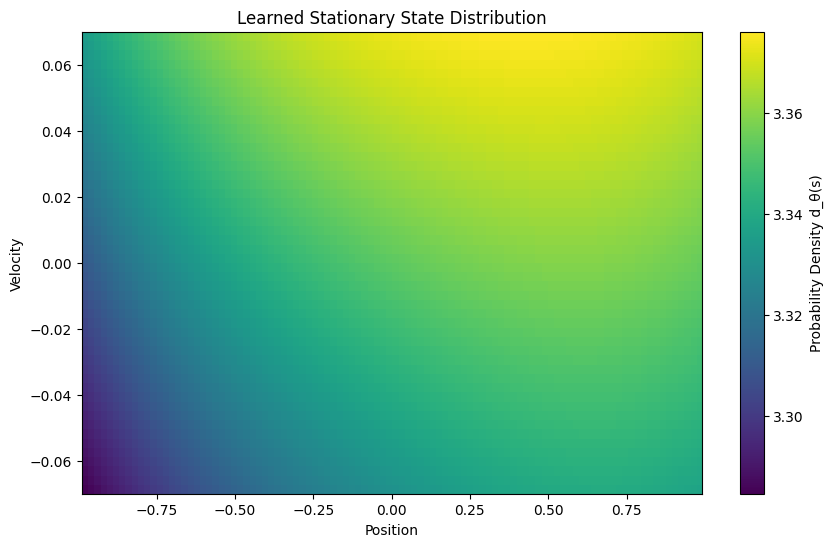

In [31]:
visualize_distribution(w_theta_net, env, device)

This makes the learned distribution d
θ
​
 (s) nearly uniform

# Make sigma increase

In [33]:
optimizer = torch.optim.Adam(w_theta_net.parameters(), lr=1e-4)
B=50

for iters in range(100):
    total_gradient_term = 0.0
    optimizer.zero_grad()
    for b in range(B):
        rff_b = RFFTestFunctions(state_dim=2, num_features=num_features, sigma=10.0, device=device)
        states ,actions, next_states, init_states = sample_batch(policy_net, N, env, device)
        states_tilde ,actions_tilde, next_states_tilde, init_states_tilde = sample_batch(policy_net, N, env, device)
        residual = compute_exact_residual(states, next_states, init_states, w_theta_net, rff_b)
        grad_loss = compute_gradient_loss(states_tilde, next_states_tilde, w_theta_net, rff_b, gamma)
        total_gradient_term += (residual.detach() * grad_loss).sum()
    final_grad = (2.0 / B) * total_gradient_term
    final_grad.backward()
    optimizer.step()
    if iters % 10 == 0:
        with torch.no_grad():
            log_rff = RFFTestFunctions(state_dim=2, num_features=num_features, device=device)
            s, _, ns, i_s = sample_batch(policy_net, N, env, device)
            residual_vector = compute_exact_residual(s, ns, i_s, w_theta_net, log_rff)
            avg_residual_magnitude = torch.mean(torch.abs(residual_vector)).item()
            s_unif, _, _, _ = sample_batch(policy_net, N, env, device)
            avg_w = w_theta_net(s_unif).mean().item()
        print(
            f"Iter {iters}: "
            f"Loss = {final_grad.item():.6f} | "
            f"Resid Magnitude = {avg_residual_magnitude:.6f} | "
            f"Avg Weight = {avg_w:.4f}"
        )

Iter 0: Loss = -0.000059 | Resid Magnitude = 0.000513 | Avg Weight = 0.9391
Iter 10: Loss = -0.000018 | Resid Magnitude = 0.000587 | Avg Weight = 1.0052
Iter 20: Loss = -0.000031 | Resid Magnitude = 0.000553 | Avg Weight = 0.9997
Iter 30: Loss = 0.000003 | Resid Magnitude = 0.000314 | Avg Weight = 0.9773
Iter 40: Loss = 0.000006 | Resid Magnitude = 0.000588 | Avg Weight = 0.9369
Iter 50: Loss = -0.000056 | Resid Magnitude = 0.000602 | Avg Weight = 0.9388
Iter 60: Loss = 0.000013 | Resid Magnitude = 0.000651 | Avg Weight = 0.9911
Iter 70: Loss = 0.000023 | Resid Magnitude = 0.000998 | Avg Weight = 1.0113
Iter 80: Loss = 0.000018 | Resid Magnitude = 0.000654 | Avg Weight = 0.9871
Iter 90: Loss = -0.000038 | Resid Magnitude = 0.000650 | Avg Weight = 0.9618


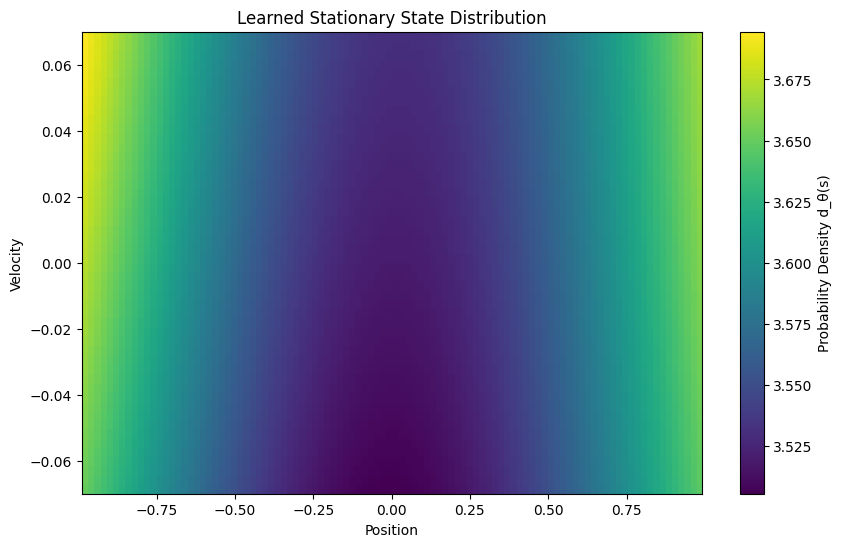

In [34]:
visualize_distribution(w_theta_net, env, device)

# Make training increase

In [13]:
optimizer = torch.optim.Adam(w_theta_net.parameters(), lr=1e-4)
B=100
for iters in range(1000):
    total_gradient_term = 0.0
    optimizer.zero_grad()
    for b in range(B):
        rff_b = RFFTestFunctions(state_dim=2, num_features=num_features, sigma=10.0, device=device)
        states ,actions, next_states, init_states = sample_batch(policy_net, N, env, device)
        states_tilde ,actions_tilde, next_states_tilde, init_states_tilde = sample_batch(policy_net, N, env, device)
        residual = compute_exact_residual(states, next_states, init_states, w_theta_net, rff_b)
        grad_loss = compute_gradient_loss(states_tilde, next_states_tilde, w_theta_net, rff_b, gamma)
        total_gradient_term += (residual.detach() * grad_loss).sum()
    final_grad = (2.0 / B) * total_gradient_term
    final_grad.backward()
    optimizer.step()
    if iters % 10 == 0:
        with torch.no_grad():
            log_rff = RFFTestFunctions(state_dim=2, num_features=num_features, device=device)
            s, _, ns, i_s = sample_batch(policy_net, N, env, device)
            residual_vector = compute_exact_residual(s, ns, i_s, w_theta_net, log_rff)
            avg_residual_magnitude = torch.mean(torch.abs(residual_vector)).item()
            s_unif, _, _, _ = sample_batch(policy_net, N, env, device)
            avg_w = w_theta_net(s_unif).mean().item()
        print(
            f"Iter {iters}: "
            f"Loss = {final_grad.item():.6f} | "
            f"Resid Magnitude = {avg_residual_magnitude:.6f} | "
            f"Avg Weight = {avg_w:.4f}"
        )

Iter 0: Loss = -0.000091 | Resid Magnitude = 0.001106 | Avg Weight = 0.7440
Iter 10: Loss = -0.000051 | Resid Magnitude = 0.000697 | Avg Weight = 0.8688
Iter 20: Loss = -0.000002 | Resid Magnitude = 0.000516 | Avg Weight = 0.9598
Iter 30: Loss = -0.000024 | Resid Magnitude = 0.000790 | Avg Weight = 0.9761
Iter 40: Loss = 0.000013 | Resid Magnitude = 0.000621 | Avg Weight = 0.9690
Iter 50: Loss = -0.000023 | Resid Magnitude = 0.000625 | Avg Weight = 0.9428
Iter 60: Loss = -0.000033 | Resid Magnitude = 0.000701 | Avg Weight = 0.9320
Iter 70: Loss = -0.000009 | Resid Magnitude = 0.000756 | Avg Weight = 0.9340
Iter 80: Loss = -0.000011 | Resid Magnitude = 0.000511 | Avg Weight = 0.9385
Iter 90: Loss = -0.000064 | Resid Magnitude = 0.000543 | Avg Weight = 0.9495
Iter 100: Loss = -0.000006 | Resid Magnitude = 0.000583 | Avg Weight = 0.9644
Iter 110: Loss = -0.000037 | Resid Magnitude = 0.000410 | Avg Weight = 0.9692
Iter 120: Loss = 0.000017 | Resid Magnitude = 0.000514 | Avg Weight = 0.9730

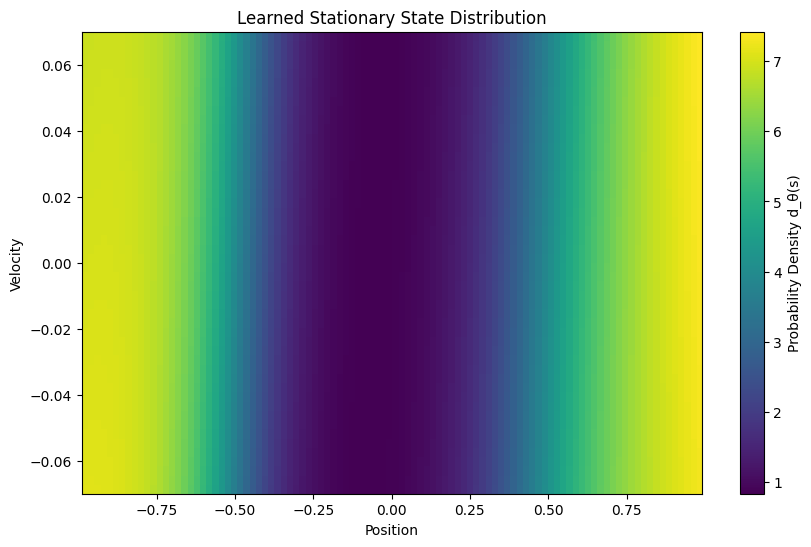

In [16]:
visualize_distribution(w_theta_net, env, device)

# Train more Longer & LR Decrease

In [ ]:
def sample_batch(policy_net, N, env, device):
    low = torch.tensor(env.low, dtype=torch.float32, device=device)
    high = torch.tensor(env.high, dtype=torch.float32, device=device)
    states = low + (high - low) * torch.rand(N, 2, device=device)
    actions = sample_policy_action(policy_net, states)
    next_states = env.vectorized_step(states, actions)
    init_states_list = []
    for _ in range(N):
        init_states_list.append(env.reset())
    init_states_np = np.array(init_states_list)
    init_states = torch.tensor(init_states_np, dtype=torch.float32, device=device)

    return states, actions, next_states, init_states

In [ ]:
optimizer = torch.optim.Adam(w_theta_net.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.9)
B=32
for iters in range(50000):
    total_gradient_term = 0.0
    optimizer.zero_grad()
    for b in range(B):
        rff_b = RFFTestFunctions(state_dim=2, num_features=num_features, sigma=10.0, device=device)
        states ,actions, next_states, init_states = sample_batch(policy_net, N, env, device)
        states_tilde ,actions_tilde, next_states_tilde, init_states_tilde = sample_batch(policy_net, N, env, device)
        residual = compute_exact_residual(states, next_states, init_states, w_theta_net, rff_b)
        grad_loss = compute_gradient_loss(states_tilde, next_states_tilde, w_theta_net, rff_b, gamma)
        total_gradient_term += (residual.detach() * grad_loss).sum()
    final_grad = (2.0 / B) * total_gradient_term
    final_grad.backward()
    optimizer.step()
    scheduler.step()
    if iters % 10 == 0:
        with torch.no_grad():
            log_rff = RFFTestFunctions(state_dim=2, num_features=num_features, device=device)
            s, _, ns, i_s = sample_batch(policy_net, N, env, device)
            residual_vector = compute_exact_residual(s, ns, i_s, w_theta_net, log_rff)
            avg_residual_magnitude = torch.mean(torch.abs(residual_vector)).item()
            s_unif, _, _, _ = sample_batch(policy_net, N, env, device)
            avg_w = w_theta_net(s_unif).mean().item()
        print(
            f"Iter {iters}: "
            f"lr {scheduler.get_last_lr()[0]:.4f} | "
            f"Loss = {final_grad.item():.6f} | "
            f"Resid Magnitude = {avg_residual_magnitude:.6f} | "
            f"Avg Weight = {avg_w:.4f}"
        )

In [ ]:
visualize_distribution(w_theta_net, env, device)

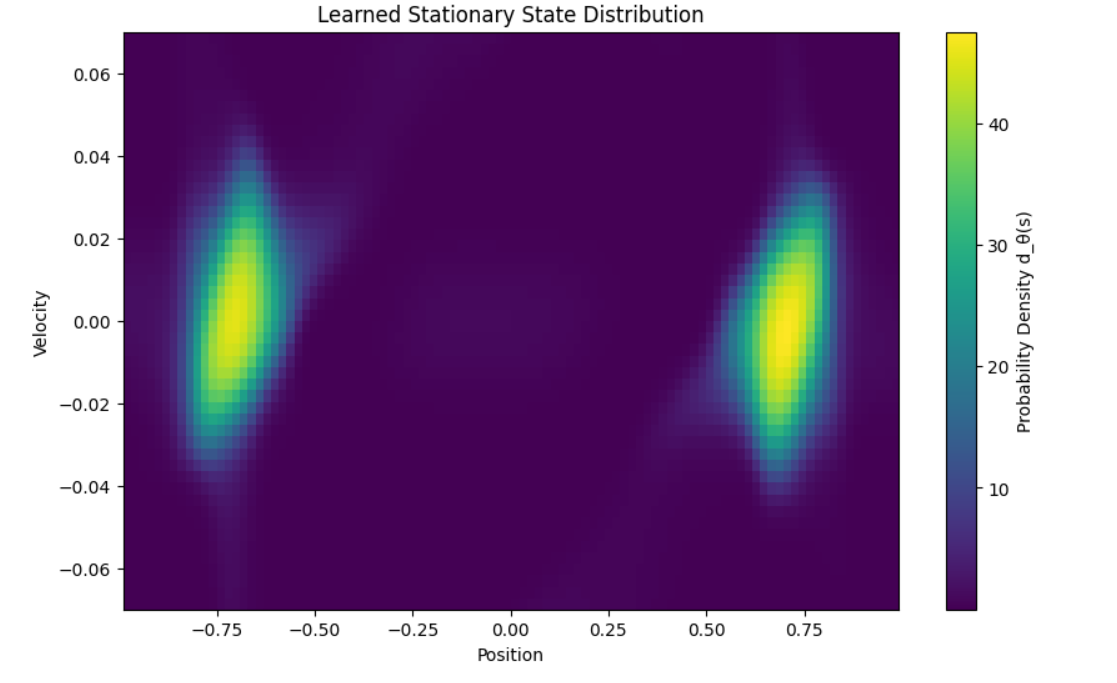

This is the result after training 9 hours